<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-starmath4/blob/main/Oct6-7/Clase_7_de_octubre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
import numpy as np
import random

def log_likelihood(x, y, parametros):
    n = len(y)
    w0, w1, sigma = parametros
    y_pred = w0 * x + w1  #polinomios de los parametros
    dif = y - y_pred
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma**2) - 0.5 * np.sum((dif / sigma)**2)
    return log_likelihood

def log_prior(parametros, int_w0, int_w1):
    if ((int_w0[0] <= parametros[0] and parametros[0]  <= int_w0[1]) and (int_w1[0] <=parametros[1]  and parametros[1]  <= int_w1[1])):
        return 0
    else:
        return -np.inf

def log_post(x, y, parametros, int_w0, int_w1):
    return log_likelihood(x, y, parametros) + log_prior(parametros, int_w0, int_w1)

In [290]:
from re import T
data=np.loadtxt("olympic100m_men.txt",delimiter=",").T #Delimitados por coma ya que es archivo separado por comas, .T indica la transpuesta
data = np.loadtxt("olympic100m_men.txt", delimiter=",").T
x = data[0][:]
y = data[1][:]

x = (x - 1896) / 4 #normalizo datos
# propongo parametros
parametros_iniciales = np.array([10.3, -0.3, 2.5])  #propongo los pesos y un sigma
sigma_proposal = np.array([0.1, 0.01, 1.0])  #desviacion

# intervalos para el prior
int_w0 = [10.2, 10.5]
int_w1 = [-0.4, -0.2]

n_cadenas = 4  # numero de cadenas
n_sample = 10000  # muestras por cadena

# arreglo para almacenar las cadenas
cadenas = []
prop=np.zeros((n_sample,3))

for i in range(n_cadenas): #genero 4 cadenas
    #inicio los parametros aceptados
    parametros_aceptados = np.zeros((n_sample, 3))
    parametros_aceptados[0] = parametros_iniciales
    log_posterior_actual = log_post(x, y, parametros_iniciales, int_w0, int_w1)
    for j in range(1, n_sample):
        propuestas = np.random.normal(parametros_aceptados[j-1], sigma_proposal)
        prop[j]=propuestas #guardo todas mis propuestas
        log_posterior_propuesto = log_post(x, y, propuestas, int_w0, int_w1)

        if log_posterior_propuesto > log_posterior_actual:
            parametros_aceptados[j] = propuestas
            log_posterior_actual = log_posterior_propuesto
        else:
          if np.log(random.uniform(0, 1)) < (log_posterior_propuesto - log_posterior_actual):
            parametros_aceptados[j] = propuestas
            log_posterior_actual = log_posterior_propuesto
          else:
            parametros_aceptados[j] = parametros_aceptados[j-1]

    #voy creando una lista de cadenas
    cadenas.append(parametros_aceptados)
print(cadenas) #imprimo las 4 cadenas

[array([[ 10.3       ,  -0.3       ,   2.5       ],
       [ 10.24355438,  -0.28631238,   2.61531833],
       [ 10.24355438,  -0.28631238,   2.61531833],
       ...,
       [ 10.25048066,  -0.27997457, 150.83842163],
       [ 10.25048066,  -0.27997457, 150.83842163],
       [ 10.3438544 ,  -0.28561566, 150.30496351]]), array([[ 10.3       ,  -0.3       ,   2.5       ],
       [ 10.22870371,  -0.2855914 ,   3.59414455],
       [ 10.22870371,  -0.2855914 ,   3.59414455],
       ...,
       [ 10.36524445,  -0.37895444, 175.18505586],
       [ 10.38443808,  -0.36039326, 174.99610363],
       [ 10.33808348,  -0.36715856, 176.00847235]]), array([[ 10.3       ,  -0.3       ,   2.5       ],
       [ 10.26752904,  -0.28301839,   2.56398676],
       [ 10.26752904,  -0.28301839,   2.56398676],
       ...,
       [ 10.38343936,  -0.3244901 , 207.11703953],
       [ 10.43172937,  -0.32269318, 209.02653722],
       [ 10.43172937,  -0.32269318, 209.02653722]]), array([[ 10.3       ,  -0.3       ,   2

In [273]:
def mean(cadena,columna):
  aux=np.zeros(len(cadena))
  for i in range(0,len(cadena)):
    aux[i]=cadena[i][1]
    mean=np.mean(aux)
  return mean
#voy a poner esta función para calcular la media de las medias mas adelante

In [291]:
#diagnóstico gelman-rubin

#nota:la media de la distribución debería ser el valor alrededor del cual se genero la distribución

def s12(parametro,cadena,columna): #varianza por cadena
  sum=0
  media=mean(cadena,columna)
  for i in range(0,len(cadena)):
    sum+=(parametro[i][columna]-cadena[i][columna])**2
  return sum/len(cadena)

def s2(parametro,cadenas,n_cadenas,columna): #varianza ya total
  sum=0
  for i in range(0,n_cadenas):
    sum+=s12(parametro,cadenas[i],columna)
  return sum/(n_cadenas)

def bn(parametro,cadenas,n_cadenas,columna):
  sum=0
  for i in range (n_cadenas):
    sum=0
    sum+=(parametro[i][columna]-mean(cadenas[i],columna))
  return sum/(n_cadenas+1)

def sigma2(parametro,cadenas,n_cadenas,columna):
  sigma=(len(cadenas[0])-1)/len(cadenas[0])*s2(parametro,cadenas,n_cadenas,columna)+bn(parametro,cadenas,n_cadenas,columna)
  return sigma

def r(parametro,cadenas,n_cadenas,columna):
  return np.sqrt(sigma2(parametro,cadenas,n_cadenas,columna)/s2(parametro,cadenas,n_cadenas,columna))

print("R=",r(prop,cadenas,n_cadenas,1))

#R tiene que ser menor que 1 para que converja

R= 0.7398997275373762


In [319]:
w0=np.zeros(n_sample)
w1=np.zeros(n_sample)
for i in range(0,n_sample):
  w0[i]=cadenas[0][i][0]
  w1[i]=cadenas[0][i][1]

[-0.3        -0.28631238 -0.28631238 ... -0.27997457 -0.27997457
 -0.28561566]


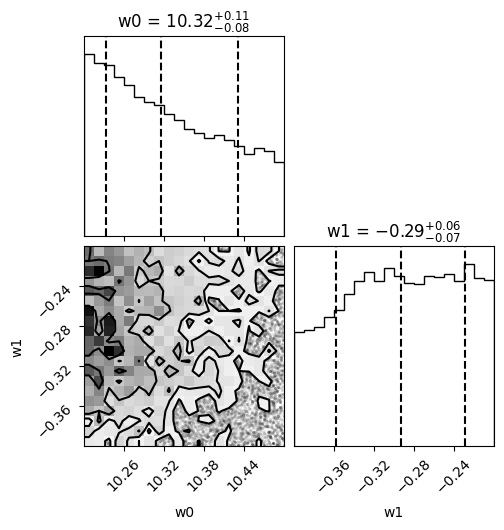

In [328]:
#Triangle plots

import numpy as np
import corner
import matplotlib.pyplot as plt

# junto todas las cadenas en una sola matriz
juntar_cadenas = np.vstack(cadenas)

names = ['w0', 'w1']

# sacar las columnas de a w0 y w1
cadenas_w0_w1 = juntar_cadenas[:, [0, 1]]

# Crear el triangle plot con w0 y w1
corner.corner(cadenas_w0_w1, labels=names, show_titles=True, quantiles=[0.16, 0.5, 0.84])

plt.show()